Loading Bank Account Fraud Dataset...
Dataset shape: (1000000, 32)
Fraud rate: 1.10%

Encoding 5 categorical features...

Data splits:
  Train: 700,400 samples (1.10% fraud)
  Val:   149,600 samples (1.10% fraud)
  Test:  150,000 samples (1.10% fraud)

Class imbalance ratio: 89.67

Configuring XGBoost with CUDA...
Creating DMatrix...

Training XGBoost...
[0]	train-auc:0.82708	train-aucpr:0.07255	train-logloss:0.66175	val-auc:0.81070	val-aucpr:0.06212	val-logloss:0.66177
[50]	train-auc:0.91823	train-aucpr:0.19118	train-logloss:0.38520	val-auc:0.88868	val-aucpr:0.15320	val-logloss:0.38703
[100]	train-auc:0.93729	train-aucpr:0.22322	train-logloss:0.34549	val-auc:0.89367	val-aucpr:0.16209	val-logloss:0.34894
[150]	train-auc:0.95002	train-aucpr:0.24539	train-logloss:0.31812	val-auc:0.89469	val-aucpr:0.16181	val-logloss:0.32346
[200]	train-auc:0.95911	train-aucpr:0.26440	train-logloss:0.29550	val-auc:0.89436	val-aucpr:0.16028	val-logloss:0.30209
[250]	train-auc:0.96600	train-aucpr:0.28414	tr

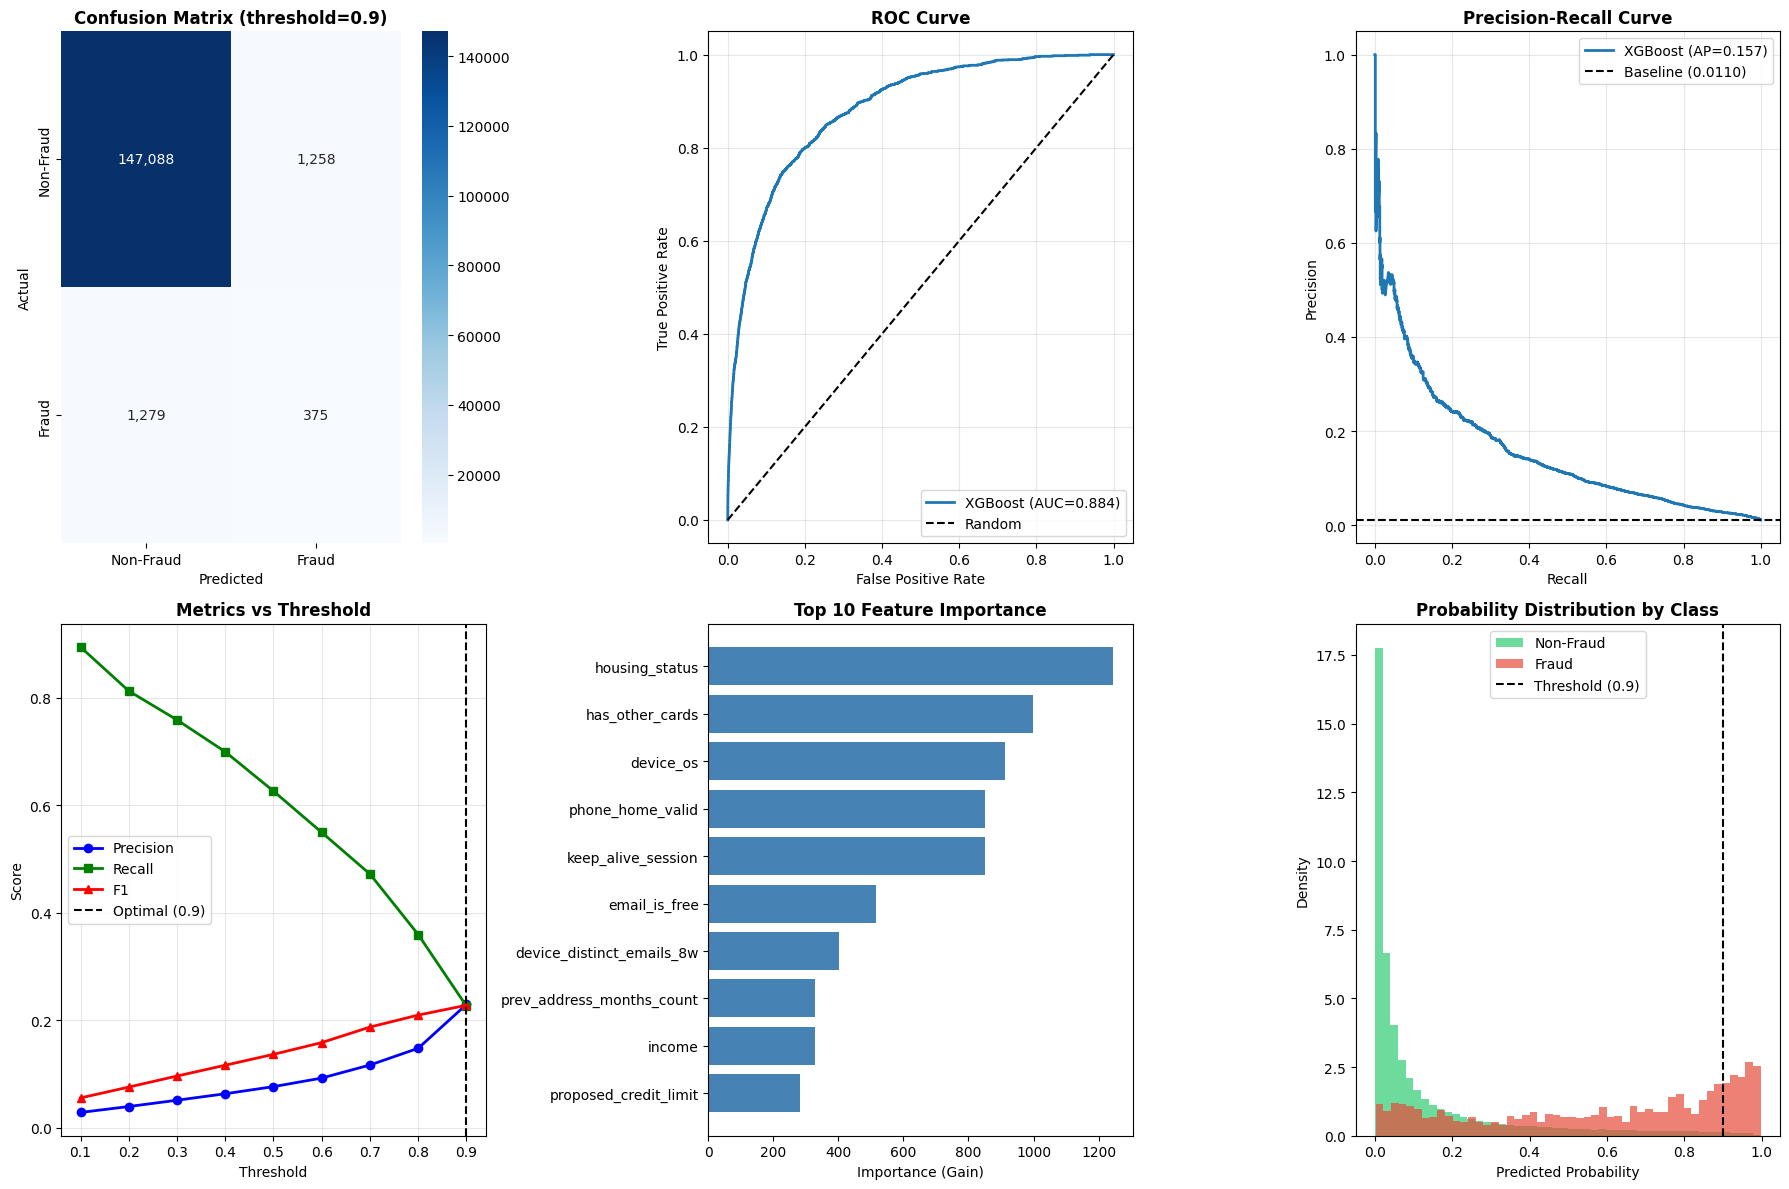


MODEL COMPARISON - SECONDARY DATASET: Neural Network vs XGBoost

                    Neural Network    XGBoost
                    --------------    -------
ROC-AUC:            0.8776            0.8835
PR-AUC:             0.1526            0.1567
Best F1:            0.1712            0.2282
Precision:          10.2%             23.0%
Recall:             52.4%             22.7%
Threshold:          0.7               0.9
Training Time:      201.6s             3.2s

✓ XGBoost model saved: ../models/secondary/xgboost_model.json
✓ Results saved: ../models/secondary/xgb_results.pkl
✓ Visualization saved: ../outputs/secondary/xgboost/evaluation_results.png


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# ===== 1. LOAD DATA =====
print("Loading Bank Account Fraud Dataset...")
df = pd.read_csv('../data/secondary/Base.csv')

target_col = 'fraud_bool'
print(f"Dataset shape: {df.shape}")
print(f"Fraud rate: {df[target_col].mean()*100:.2f}%")

# ===== 2. ENCODE CATEGORICAL FEATURES =====
categorical_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

print(f"\nEncoding {len(categorical_cols)} categorical features...")
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# ===== 3. PREPARE FEATURES AND TARGET =====
X = df.drop(target_col, axis=1)
y = df[target_col]

# ===== 4. TRAIN/VAL/TEST SPLIT (same as NN) =====
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"\nData splits:")
print(f"  Train: {X_train.shape[0]:,} samples ({y_train.mean()*100:.2f}% fraud)")
print(f"  Val:   {X_val.shape[0]:,} samples ({y_val.mean()*100:.2f}% fraud)")
print(f"  Test:  {X_test.shape[0]:,} samples ({y_test.mean()*100:.2f}% fraud)")

# ===== 5. CLASS WEIGHT =====
fraud_count = y_train.sum()
non_fraud_count = len(y_train) - fraud_count
scale_pos_weight = non_fraud_count / fraud_count
print(f"\nClass imbalance ratio: {scale_pos_weight:.2f}")

# ===== 6. CONFIGURE XGBOOST =====
print("\nConfiguring XGBoost with CUDA...")

params = {
    'device': 'cuda',
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric': ['auc', 'aucpr', 'logloss'],
    'scale_pos_weight': scale_pos_weight,
    'max_depth': 6,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'learning_rate': 0.1,
    'random_state': 42,
}

# ===== 7. CREATE DMatrix =====
print("Creating DMatrix...")
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# ===== 8. TRAIN MODEL =====
print("\nTraining XGBoost...")
start_time = time.time()

evals = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=50
)

training_time = time.time() - start_time
print(f"\n✓ Training complete in {training_time:.1f} seconds")
print(f"Best iteration: {model.best_iteration}")

# ===== 9. GET PREDICTIONS =====
print("\nGenerating predictions...")
y_probs = model.predict(dtest)

print(f"Probability range: {y_probs.min():.4f} to {y_probs.max():.4f}")
print(f"Probability mean: {y_probs.mean():.4f}")
print(f"Probability std: {y_probs.std():.4f}")

# ===== 10. THRESHOLD OPTIMIZATION =====
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION")
print("="*70)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for thresh in thresholds:
    preds = (y_probs >= thresh).astype(int)

    tp = ((preds == 1) & (y_test == 1)).sum()
    fp = ((preds == 1) & (y_test == 0)).sum()
    fn = ((preds == 0) & (y_test == 1)).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    results.append({
        'threshold': thresh,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn
    })

print(f"\n{'Thresh':<8} {'Precision':<12} {'Recall':<10} {'F1':<10} {'TP':<8} {'FP':<10} {'FN':<8}")
print("-" * 75)
for r in results:
    print(f"{r['threshold']:<8.1f} {r['precision']:<12.4f} {r['recall']:<10.4f} {r['f1']:<10.4f} {r['tp']:<8} {r['fp']:<10} {r['fn']:<8}")

best_result = max(results, key=lambda x: x['f1'])
print(f"\n✓ Optimal Threshold: {best_result['threshold']}")
print(f"  Precision: {best_result['precision']:.4f}")
print(f"  Recall: {best_result['recall']:.4f}")
print(f"  F1: {best_result['f1']:.4f}")

# ===== 11. FINAL METRICS =====
optimal_preds = (y_probs >= best_result['threshold']).astype(int)

roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

print(f"\nROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, optimal_preds, target_names=['Non-Fraud', 'Fraud'], digits=4))

# ===== 12. FEATURE IMPORTANCE =====
print("\n" + "="*70)
print("FEATURE IMPORTANCE")
print("="*70)

importance = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': importance.keys(),
    'importance': importance.values()
}).sort_values('importance', ascending=False)

print("\nTop 10 Features:")
for idx, row in importance_df.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.2f}")

# ===== 13. VISUALIZATIONS =====
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Confusion Matrix
cm = confusion_matrix(y_test, optimal_preds)
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_title(f'Confusion Matrix (threshold={best_result["threshold"]})', fontweight='bold')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'XGBoost (AUC={roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision-Recall Curve
precisions_curve, recalls_curve, _ = precision_recall_curve(y_test, y_probs)
axes[0, 2].plot(recalls_curve, precisions_curve, linewidth=2, label=f'XGBoost (AP={pr_auc:.3f})')
axes[0, 2].axhline(y=y_test.mean(), color='k', linestyle='--', label=f'Baseline ({y_test.mean():.4f})')
axes[0, 2].set_xlabel('Recall')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].set_title('Precision-Recall Curve', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Threshold vs Metrics
thresholds_plot = [r['threshold'] for r in results]
precisions_plot = [r['precision'] for r in results]
recalls_plot = [r['recall'] for r in results]
f1s_plot = [r['f1'] for r in results]

axes[1, 0].plot(thresholds_plot, precisions_plot, 'b-o', label='Precision', linewidth=2)
axes[1, 0].plot(thresholds_plot, recalls_plot, 'g-s', label='Recall', linewidth=2)
axes[1, 0].plot(thresholds_plot, f1s_plot, 'r-^', label='F1', linewidth=2)
axes[1, 0].axvline(x=best_result['threshold'], color='black', linestyle='--', label=f'Optimal ({best_result["threshold"]})')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Metrics vs Threshold', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Feature Importance
top_features = importance_df.head(10)
axes[1, 1].barh(top_features['feature'], top_features['importance'], color='steelblue')
axes[1, 1].set_xlabel('Importance (Gain)')
axes[1, 1].set_title('Top 10 Feature Importance', fontweight='bold')
axes[1, 1].invert_yaxis()

# Probability Distribution
axes[1, 2].hist(y_probs[y_test == 0], bins=50, alpha=0.7, label='Non-Fraud', color='#2ecc71', density=True)
axes[1, 2].hist(y_probs[y_test == 1], bins=50, alpha=0.7, label='Fraud', color='#e74c3c', density=True)
axes[1, 2].axvline(x=best_result['threshold'], color='black', linestyle='--', label=f'Threshold ({best_result["threshold"]})')
axes[1, 2].set_xlabel('Predicted Probability')
axes[1, 2].set_ylabel('Density')
axes[1, 2].set_title('Probability Distribution by Class', fontweight='bold')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig('../outputs/secondary/xgboost/evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== 14. SAVE MODEL AND RESULTS =====
model.save_model('../models/secondary/xgboost_model.json')

xgb_results = {
    'model': 'XGBoost',
    'dataset': 'Secondary (Bank Account Fraud)',
    'roc_auc': roc_auc,
    'pr_auc': pr_auc,
    'best_f1': best_result['f1'],
    'precision': best_result['precision'],
    'recall': best_result['recall'],
    'optimal_threshold': best_result['threshold'],
    'training_time': training_time,
    'best_iteration': model.best_iteration
}

with open('../models/secondary/xgb_results.pkl', 'wb') as f:
    pickle.dump(xgb_results, f)

# ===== 15. LOAD NN RESULTS FOR COMPARISON =====
with open('../models/secondary/nn_results.pkl', 'rb') as f:
    nn_results = pickle.load(f)

print("\n" + "="*70)
print("MODEL COMPARISON - SECONDARY DATASET: Neural Network vs XGBoost")
print("="*70)
print(f"""
                    Neural Network    XGBoost
                    --------------    -------
ROC-AUC:            {nn_results['roc_auc']:.4f}            {roc_auc:.4f}
PR-AUC:             {nn_results['pr_auc']:.4f}            {pr_auc:.4f}
Best F1:            {nn_results['best_f1']:.4f}            {best_result['f1']:.4f}
Precision:          {nn_results['precision']*100:.1f}%             {best_result['precision']*100:.1f}%
Recall:             {nn_results['recall']*100:.1f}%             {best_result['recall']*100:.1f}%
Threshold:          {nn_results['optimal_threshold']}               {best_result['threshold']}
Training Time:      {nn_results['training_time']:.1f}s             {training_time:.1f}s
""")

print("✓ XGBoost model saved: ../models/secondary/xgboost_model.json")
print("✓ Results saved: ../models/secondary/xgb_results.pkl")
print("✓ Visualization saved: ../outputs/secondary/xgboost/evaluation_results.png")